In [13]:
import napari
viewer = napari.Viewer()

from tqdm import tqdm
from tnia.deeplearning.dl_helper import quantile_normalization
import matplotlib.pyplot as plt
import numpy as np

import torch
from tnia.deeplearning.dl_helper import collect_training_data, divide_training_data
from tnia.plotting.plt_helper import imshow_multi2d
from skimage.io import imread

In [14]:
cuda_present = torch.cuda.is_available()
ndevices = torch.cuda.device_count()
use_cuda = cuda_present and ndevices > 0
device = torch.device("cuda" if use_cuda else "cpu")  # "cuda:0" ... default device, "cuda:1" would be GPU index 1, "cuda:2" etc
print("number of devices:", ndevices, "\tchosen device:", device, "\tuse_cuda=", use_cuda)

number of devices: 1 	chosen device: cuda 	use_cuda= True


In [15]:
from pathlib import Path
import os

tnia_images_path = Path(r"D:\images")
parent_path = r'D:\images\tnia-python-images\imagesc\2025_02_10_semantic_rgb'

train_path = os.path.join(parent_path, 'patches')

image_patch_path = train_path + '/ground truth0'
label_patch_path = train_path + '/input0'

model_path = os.path.join(parent_path,'models')

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(image_patch_path):
    print('image_patch_path does not exist')

if not os.path.exists(label_patch_path):
    print('label_patch_path does not exist')

In [18]:
dtype = torch.LongTensor

net = torch.load( Path(model_path) / 'feb11.pth')
device = torch.device("cuda")
net=net.to(device)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = net.to(device)



In [19]:
parent_path = Path(parent_path)
models_path = Path(parent_path) / 'models'

im_name = 'img87.tif'
im = imread(str(parent_path / (im_name)))

print(im.min(), im.max(), im.mean(), im.shape)
im = quantile_normalization(im)
print(im.min(), im.max(), im.mean(), im.shape)

im_to_test = im#[0:1024, 0:1024, :]



0 65535 10086.965876439326 (747, 756, 3)
0.0 1.0 0.15419721831704888 (747, 756, 3)


In [20]:
im_to_test.dtype
net.eval()

BasicUNet(
  (conv_0): TwoConv(
    (conv_0): Convolution(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
      )
    )
    (conv_1): Convolution(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (down_1): Down(
    (max_pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (convs): TwoConv(
      (conv_0): Convolution(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (adn): ADN(
          (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (D): Dropout(p=0.0, inplace=False

torch.Size([1, 3, 747, 756]) (3, 747, 756)


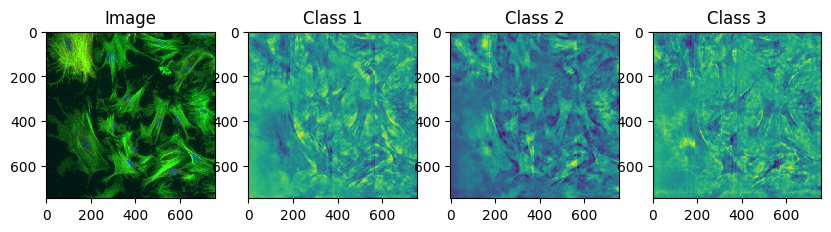

In [21]:
features = im_to_test.transpose(2,0,1).astype(np.float32)

features_tensor = torch.from_numpy(features).unsqueeze(0).to(device)       
#features = features.todevice()
with torch.no_grad():
    #predicted = net(features_tensor)
    outputs = []
    for chunk in torch.chunk(features_tensor, chunks=4, dim=3):  # Divide input into smaller parts
        
        with torch.no_grad():
            outputs.append(net(chunk))
        del chunk
        torch.cuda.empty_cache()
    predicted = torch.cat(outputs, dim=3)


print(predicted.shape, features.shape)

features = np.transpose(features, (1,2,0))

predicted.shape
c1 = predicted[0,0,:,:].cpu().detach().numpy()
c2 = predicted[0,1,:,:].cpu().detach().numpy()
c3 = predicted[0,2,:,:].cpu().detach().numpy()
fig = imshow_multi2d([features, c1, c2, c3], ['Image', 'Class 1', 'Class 2', 'Class 3'], 1, 4, 10, 10,colormaps=['gray', 'viridis', 'viridis', 'viridis'])

torch.Size([1, 3, 747, 756])


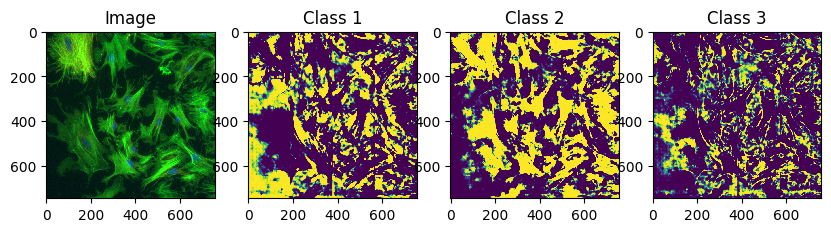

In [22]:
import torch.nn.functional as F

# Apply softmax along the class dimension (dim=1)
probabilities = F.softmax(predicted, dim=1)
predicted_classes = torch.argmax(probabilities, dim=1)

p1 = probabilities[0,0,:,:].cpu().detach().numpy()
p2 = probabilities[0,1,:,:].cpu().detach().numpy()
p3 = probabilities[0,2,:,:].cpu().detach().numpy()
fig = imshow_multi2d([features, p1, p2, p3], ['Image', 'Class 1', 'Class 2', 'Class 3'], 1, 4, 10, 10,colormaps=['gray', 'viridis', 'viridis', 'viridis'])

print(probabilities.shape)

In [23]:

edges = predicted_classes.cpu().detach().numpy()

edges = edges+1
edges[edges!=2] = 0
edges.shape
viewer.add_labels(edges, name='edges')

<Labels layer 'edges' at 0x1afaaadb970>

In [24]:
viewer.add_image(features, contrast_limits=[0,1])
viewer.add_image(c1)
viewer.add_image(c2)
viewer.add_image(c3)
viewer.add_labels(predicted_classes[0].cpu().detach().numpy()+1)

<Labels layer 'Labels' at 0x1afd44cf640>

In [25]:
viewer.add_image(im)

<Image layer 'im' at 0x1afa75a1c00>

In [ ]:
viewer.add_labels(edges)